In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import nltk
import collections
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from scipy import spatial
import matplotlib.pyplot as plt

In [ ]:
def create_pairs(x, y):

  pairs_list = []
  labels_list = []

  for i in range(len(x)):
    for j in range(len(x)):
      if i == j:
        continue;
      if j < i:
        continue;
      pairs_list.append((x[i], x[j]))
      labels_list.append((y[i][0], y[j][0]))

  return np.array(pairs_list), np.array(labels_list)

In [ ]:
!pip install spacy-sentence-bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.5 MB/s eta 0:00:00
  Created wheel for spacy-sentence-bert: filename=spacy_sentence_bert-0.1.2-py3-none-any.whl size=27201 sha256=cbd04f451032d43668cef0d24171d010bad294a41bf16a6210869053631018b4
  Stored in directory: /root/.cache/pip/wheels/e9/3d/c9/a2e13b1a9dcaacca18d82bd7154ab95d1cea35d707c472a133
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=3b126c0e56a791bc10367

In [ ]:
import spacy_sentence_bert
import spacy

In [ ]:
nlp = spacy_sentence_bert.load_model('en_stsb_roberta_large')

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/674 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
# https://keras.io/examples/vision/siamese_contrastive/
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    x = tf.math.l2_normalize(x)
    y = tf.math.l2_normalize(y)
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    output = tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))
    return output

def cosine_sim(vects):
    x, y = vects
    x = tf.math.l2_normalize(x)
    y = tf.math.l2_normalize(y)

    return tf.multiply(x,y)

def loss(margin=0.5):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):

        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """


        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

        # return tfa.losses.contrastive_loss(y_true, square_pred, margin=0.5)

    return contrastive_loss


In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import f1_score

df = pd.read_csv("/content/drive/MyDrive/NLP_Projekt/IMDB Dataset.csv").iloc[:200,:]
y = np.asarray(df.iloc[:,1])
y[y=="positive"] = 1
y[y=="negative"] = 0
y = y.reshape(-1,1).astype('float32')
X = np.array([nlp(df.iloc[i,0]).vector for i in range(df.shape[0])])

skf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=123)
skf.get_n_splits(X, y)

accuracy_list = []
f1_score_list = []

for train_index, test_index in skf.split(X, y):

  # Select random subsamples
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  X_train = np.array(X_train)
  X_test = np.array(X_test)
  X_train.shape

  df2 = pd.read_csv("/content/drive/MyDrive/NLP_Projekt/IMDB Dataset.csv").iloc[200:1200,:]
  y_test = np.asarray(df2.iloc[:,1])
  y_test[y_test=="positive"] = 1
  y_test[y_test=="negative"] = 0
  y_test = y_test.reshape(-1,1).astype('float32')
  X_test = np.array([nlp(df2.iloc[i,0]).vector for i in range(df2.shape[0])])
  X_test = np.array(X_test)



  # create pairs
  x_train_pairs, y_train_labels = create_pairs(X_train, y_train)
  # x_test_pairs, y_test_labels = create_pairs(X_test, y_test)
  # if labels are the same -> label 0
  # if labels are not the same -> label 1
  y_train_labels = np.where(y_train_labels[:,0] == y_train_labels[:,1], 0, 1)

  # https://keras.io/examples/vision/siamese_contrastive/
  # Provided two tensors t1 and t2
  # Euclidean distance = sqrt(sum(square(t1-t2)))

  len_bag = x_train_pairs.shape[2]

  input = layers.Input((len_bag,))
  x = tf.keras.layers.BatchNormalization()(input)
  x = layers.Dense(2048)(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(1024)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(512)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(256)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(128)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(32)(x)

  embedding_network = tf.keras.Model(input, x)


  input_1 = layers.Input((len_bag,))
  input_2 = layers.Input((len_bag,))

  # As mentioned above, Siamese Network share weights between
  # tower networks (sister networks). To allow this, we will use
  # same embedding network for both tower networks.
  tower_1 = embedding_network(input_1)
  tower_2 = embedding_network(input_2)

  merge_layer = layers.Lambda(cosine_sim)([tower_1, tower_2])
  normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
  output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
  siamese = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

  siamese.compile(loss=loss(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=["accuracy"], run_eagerly=True)
  siamese.summary()

  x_train_1 = x_train_pairs[:,0,:]
  x_train_2 = x_train_pairs[:,1,:]

  # x_test_1 = x_test_pairs[:,0,:]
  # x_test_2 = x_test_pairs[:,1,:]

  x_train_1 = tf.convert_to_tensor(x_train_1)
  x_train_2 = tf.convert_to_tensor(x_train_2)

  # x_test_1 = tf.convert_to_tensor(x_test_1)
  # x_test_2 = tf.convert_to_tensor(x_test_2)

  y_train_labels = tf.convert_to_tensor(y_train_labels)
  # y_test_labels = tf.convert_to_tensor(y_test_labels)


  y_train_labels = tf.cast(y_train_labels, tf.float32)
  # y_test_labels = tf.cast(y_test_labels, tf.float32)

  # x_test_1 = tf.cast(x_test_1, tf.float32)
  # x_test_2 = tf.cast(x_test_2, tf.float32)

  x_train_1 = tf.cast(x_train_1, tf.float32)
  x_train_2 = tf.cast(x_train_2, tf.float32)


  history = siamese.fit(
      [x_train_1, x_train_2],
      y_train_labels,
      batch_size=32,
      epochs=5
  )

  # a = siamese.predict([x_test_1, x_test_2])
  # results = pd.DataFrame(a)
  # results["true"] = y_test_labels[:,1]
  # results.iloc[:50,:]

  # plt.figure(figsize=(8,10))
  # plt.hist(results[results["true"] == 0][0], color="orange", alpha = 0.5)
  # plt.hist(results[results["true"] == 1][0], color="skyblue", alpha = 0.5)
  # plt.legend(["class 0", "class 1"])
  # plt.title("Probability vs actual")
  # plt.show()

  preds = []

  for i in range(len(X_test)):
      pairs_list = []

      for j in range(len(X_train)):
          pairs_list.append((X_test[i], X_train[j]))

      pairs_list = np.array(pairs_list)

      b = siamese.predict([pairs_list[:,0,:], pairs_list[:,1,:]])
      
      # class assigned with mean probability 
      #preds.append(int(b[np.where(y_train.flatten() == 0)].mean() > b[np.where(y_train.flatten() == 1)].mean()))

      # class assigned with kNN
      #preds.append(int(np.sum(y_train.flatten()[np.argpartition(b.flatten(), -1)[-1:]]) < 1/2))
      #preds.append(int(np.sum(y_train.flatten()[np.argpartition(b.flatten(), -3)[-3:]]) < 3/2))
      #preds.append(int(np.sum(y_train.flatten()[np.argpartition(b.flatten(), -5)[-5:]]) < 5/2))
      preds.append(int(np.sum(y_train.flatten()[np.argpartition(b.flatten(), -7)[-7:]]) < 7/2))
      #preds.append(int(np.sum(y_train.flatten()[np.argpartition(b.flatten(), -9)[-9:]]) < 9/2))

  accuracy_list.append(np.mean(y_test.flatten()==preds))
  print("Accuracy:")
  print(np.mean(y_test.flatten()==preds))
  f1_score_list.append(f1_score(y_test.flatten(), preds))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 model (Functional)             (None, 32)           4902304     ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 32)           0           ['model[0][0]',            

In [ ]:
# MEAN 
# accuracy_list [0.789, 0.77, 0.772, 0.757]
# f1_score_list [0.8011310084825636, 0.7762645914396886, 0.772, 0.7772685609532537]
# 3 Nearest Neighbors
# accuracy_list [0.7747777777777778, 0.777, 0.7574444444444445, 0.7704444444444445]
# f1_score_list [0.7787359458574391, 0.7797168258149489, 0.749856766357282, 0.7840267614467907]
# 7 Nearest Neighbors
# accuracy_list [0.777, 0.78, 0.761, 0.758]
# f1_score_list [0.7913938260056127, 0.7868217054263567, 0.7578520770010132, 0.7791970802919709]

In [ ]:
accuracy_list

[0.777, 0.78, 0.761, 0.758]

In [ ]:
f1_score_list

[0.7913938260056127,
 0.7868217054263567,
 0.7578520770010132,
 0.7791970802919709]

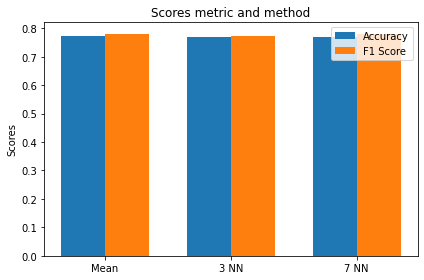

In [ ]:
labels = ['Mean', '3 NN', '7 NN']
acc_means = [np.mean([0.789, 0.77, 0.772, 0.757]), np.mean([0.7747777777777778, 0.777, 0.7574444444444445, 0.7704444444444445]), np.mean([0.777, 0.78, 0.761, 0.758])]
f1_means = [np.mean([0.8011310084825636, 0.7762645914396886, 0.772, 0.7772685609532537]), np.mean([0.7787359458574391, 0.7797168258149489, 0.749856766357282, 0.7840267614467907]), np.mean([0.7913938260056127, 0.7868217054263567, 0.7578520770010132, 0.7791970802919709])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, acc_means, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_means, width, label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores metric and method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()